# Modelling

## Import

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, losses, optimizers, metrics, callbacks
from keras.models import load_model

import matplotlib.pyplot as plt

In [2]:
#temporary solutions
%run ../scripts/save_utils.py
%run ../scripts/loss_recall_plot.py
%run ../notebooks/loader_modelling.ipynb

the object from ../save_files/callbacks/stop_early.pkl has been successfully loaded.
the object from ../save_files/evaluation/baseline_train_results.pkl has been successfully loaded.
the object from ../save_files/evaluation/baseline_test_results.pkl has been successfully loaded.
the object from ../save_files/train_log/baseline_train_log.pkl has been successfully loaded.
the object from ../save_files/train_log/baseline_num_epochs.pkl has been successfully loaded.
the object from ../save_files/evaluation/augmented_train_results.pkl has been successfully loaded.
the object from ../save_files/evaluation/augmented_test_results.pkl has been successfully loaded.
the object from ../save_files/train_log/augmented_train_log.pkl has been successfully loaded.
the object from ../save_files/train_log/augmented_num_epochs.pkl has been successfully loaded.
the object from ../save_files/train_log/additional_augmented_train_log.pkl has been successfully loaded.
the object from ../save_files/train_log/ad

In [3]:
# ------------------------- models
#baseline_model = load_ml_model('../save_files/models/baseline.h5')
#augmented_model = load_ml_model('../save_files/models/augmented.h5')
#augmented_model_backup = load_ml_model('../save_files/models/augmented_backup.h5')

#dropout_augmented_model_backup = load_ml_model('../save_files/models/dropout_augmented_backup.h5')

the model from ../save_files/models/dropout_augmented_backup.h5 has been successfully loaded.


## Baseline model

### ImageDataGenerator

Let's initialize data generators. Most importantly, they will rescale vectorized images such that the values are going to be in range 0-1.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Now we need to specify the directories in which these images reside. I have decided to keep original resolution of 512x512 pixels. The *batch_size* is relatively small to reduce memory usage.

In [8]:
train_generator = train_datagen.flow_from_dataframe(df_train, '..\\data\\raw\\merged_data\\',
                                                    x_col='image_path', y_col='label',
                                                    target_size=(512, 512), batch_size=8,
                                                    class_mode='categorical', validate_filenames=False)

validation_generator = val_datagen.flow_from_dataframe(df_val, '..\\data\\raw\\merged_data\\',
                                                       x_col='image_path', y_col='label',
                                                       target_size=(512, 512), batch_size=8,
                                                       class_mode='categorical', validate_filenames=False)

test_generator = test_datagen.flow_from_dataframe(df_test, '..\\data\\raw\\merged_data\\',
                                                  x_col='image_path', y_col='label',
                                                  target_size=(512, 512), batch_size=8,
                                                  class_mode='categorical', validate_filenames=False)

Found 4213 non-validated image filenames belonging to 4 classes.
Found 1405 non-validated image filenames belonging to 4 classes.
Found 1405 non-validated image filenames belonging to 4 classes.


Now we initialize a baseline model. Notice that I have used *clear_session* to reset all variables that model might save before each use of the model (i.e. when re-running notebook).

In [6]:
tf.keras.backend.clear_session()

baseline_model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')

])

baseline_model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.Recall()])

In [7]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

We will also make a callback to invoke early stop. It will monitor validation loss, since we want to minimize it as much as possible.

In [8]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=8)
save_data(stop_early, 'callback', '../save_files/callbacks/stop_early.pkl')

object successfully saved to: ../save_files/callbacks/stop_early.pkl.


We set *steps_per_epoch* to 500 since *batch_size* is set to 8 and we have approx. 4000 samples in the training set. Thus, to cover as much train data as possible, we will need 500 batches of 8 images.

In [9]:
baseline_history = baseline_model.fit(train_generator, steps_per_epoch=500, epochs=30, validation_data=validation_generator, validation_steps=175, callbacks=[stop_early], verbose=1)

Epoch 1/30
500/500 [==============================] - 71s 126ms/step - loss: 0.7947 - recall: 0.6045 - val_loss: 0.4215 - val_recall: 0.8314
Epoch 2/30
500/500 [==============================] - 58s 117ms/step - loss: 0.2757 - recall: 0.8909 - val_loss: 0.3248 - val_recall: 0.8707
Epoch 3/30
500/500 [==============================] - 58s 116ms/step - loss: 0.1215 - recall: 0.9600 - val_loss: 0.4385 - val_recall: 0.8693
Epoch 4/30
500/500 [==============================] - 58s 115ms/step - loss: 0.0628 - recall: 0.9822 - val_loss: 0.4430 - val_recall: 0.9021
Epoch 5/30
500/500 [==============================] - 58s 115ms/step - loss: 0.0137 - recall: 0.9950 - val_loss: 0.6421 - val_recall: 0.8921
Epoch 6/30
500/500 [==============================] - 58s 115ms/step - loss: 0.0320 - recall: 0.9905 - val_loss: 0.7660 - val_recall: 0.8593
Epoch 7/30
500/500 [==============================] - 57s 114ms/step - loss: 0.1161 - recall: 0.9737 - val_loss: 0.4674 - val_recall: 0.9050
Epoch 8/30
50

It is a good practise to save a model after training to be able to use it whenever we want without the need to retrain it if for some reason we would have lost its parameters.

In [10]:
#save_data(baseline_history, 'history', '../save_files/history/baseline_history.pkl')
baseline_model.save('../save_files/models/baseline.h5')

And now we evaluate the model on **test** data:

In [11]:
baseline_train_results = baseline_model.evaluate(train_generator, batch_size=32, return_dict=True)
baseline_test_results = baseline_model.evaluate(test_generator, batch_size=32, return_dict=True)

save_data(baseline_train_results, 'evaluation_data', '../save_files/evaluation/baseline_train_results.pkl')
save_data(baseline_test_results, 'evaluation_data', '../save_files/evaluation/baseline_test_results.pkl')

176/176 [==============================] - 6s 33ms/step - loss: 1.2368 - recall: 0.8548
object successfully saved to: ../save_files/evaluation/baseline_train_results.pkl.
object successfully saved to: ../save_files/evaluation/baseline_test_results.pkl.


In [12]:
print('Evaluation results for baseline model:\n')
print('train loss:   ', baseline_train_results['loss'])
print('train recall: ', baseline_train_results['recall'])
print()
print('test loss:    ', baseline_test_results['loss'])
print('test recall:  ', baseline_test_results['recall'])

Evaluation results for baseline model:

train loss:  0.1103089228272438
train recall:  0.9807738065719604

test loss:    1.2367511987686157
test recall:  0.854804277420044


We got very good results even for the baseline model.  
  
Let's now visualize its training and evaluation process to see how it behaves.

### Baseline training and validation visualization

In [13]:
baseline_train_log = baseline_history.history
baseline_num_epochs = np.arange(1, len(baseline_train_log['loss'])+1)

save_data(baseline_train_log, 'train_log', '../save_files/train_log/baseline_train_log.pkl')
save_data(baseline_num_epochs, 'epochs', '../save_files/train_log/baseline_num_epochs.pkl')

object successfully saved to: ../save_files/train_log/baseline_train_log.pkl.
object successfully saved to: ../save_files/train_log/baseline_num_epochs.pkl.


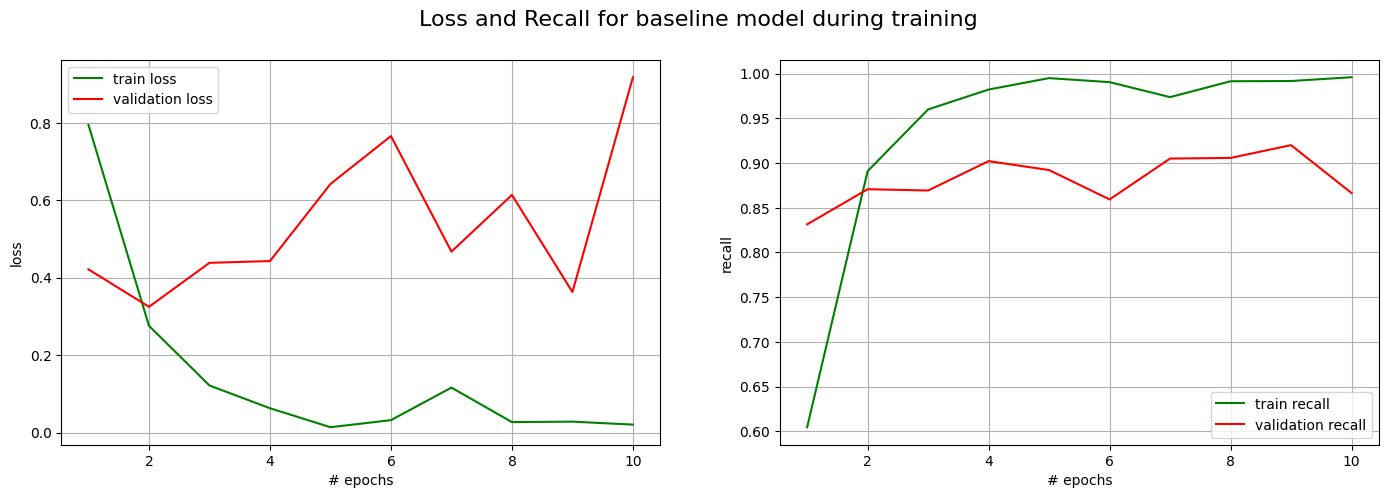

In [14]:
loss_recall_plot(baseline_train_log, 'Loss and Recall for baseline model during training')

We see that model **overfits** just after a couple of epochs. This may come from the fact that training set is quite small (approx. 4000 images).

## Augmentation

Let's introduce some random augmentation to initial images. This way we will be able to train the model on the more generalized data to hopefully reduce overfitting.

In [5]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator_aug = train_aug.flow_from_dataframe(df_train, '..\\data\\raw\\merged_data\\',
                                                            x_col='image_path', y_col='label',
                                                            target_size=(512, 512), batch_size=8,
                                                            class_mode='categorical', validate_filenames=False)

Found 4213 non-validated image filenames belonging to 4 classes.


We will use the same architecture of the model as before:

In [6]:
tf.keras.backend.clear_session()

augmented_model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

augmented_model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.Recall()])

In [7]:
augmented_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

In [8]:
augmented_history = augmented_model.fit(train_generator_aug, steps_per_epoch=500, epochs=30,
                                              validation_data=validation_generator, validation_steps=175,
                                              callbacks=[stop_early], verbose=1)

Epoch 1/30
500/500 [==============================] - 167s 313ms/step - loss: 1.1915 - recall: 0.1636 - val_loss: 1.1093 - val_recall: 0.2564
Epoch 2/30
500/500 [==============================] - 153s 306ms/step - loss: 1.0523 - recall: 0.2119 - val_loss: 0.9810 - val_recall: 0.2479
Epoch 3/30
500/500 [==============================] - 152s 303ms/step - loss: 0.9710 - recall: 0.2825 - val_loss: 0.9557 - val_recall: 0.4500
Epoch 4/30
500/500 [==============================] - 151s 302ms/step - loss: 0.8957 - recall: 0.4158 - val_loss: 0.8544 - val_recall: 0.5807
Epoch 5/30
500/500 [==============================] - 151s 302ms/step - loss: 0.8385 - recall: 0.4939 - val_loss: 0.7396 - val_recall: 0.5993
Epoch 6/30
500/500 [==============================] - 155s 309ms/step - loss: 0.8118 - recall: 0.5279 - val_loss: 0.7753 - val_recall: 0.6200
Epoch 7/30
500/500 [==============================] - 153s 305ms/step - loss: 0.7880 - recall: 0.5437 - val_loss: 0.7275 - val_recall: 0.6457
Epoch 

In [9]:
augmented_model.save('../save_files/models//augmented.h5')

Let's now evaluate the model on the same train data as well as test data to compare the results and see if we have overfitting:

In [10]:
augmented_train_results = augmented_model.evaluate(train_generator_aug, batch_size=32, return_dict=True)
augmented_test_results = augmented_model.evaluate(test_generator, batch_size=32, return_dict=True)

save_data(augmented_train_results, 'evaluation_data', '../save_files/evaluation/augmented_train_results.pkl')
save_data(augmented_test_results, 'evaluation_data', '../save_files/evaluation/augmented_test_results.pkl')

176/176 [==============================] - 6s 32ms/step - loss: 0.4708 - recall: 0.7680
object successfully saved to: ../save_files/evaluation/augmented_train_results.pkl.
object successfully saved to: ../save_files/evaluation/augmented_test_results.pkl.


In [11]:
print('Evaluation results for model with augmented images input:\n')
print('train loss:   ', augmented_train_results['loss'])
print('train recall: ', augmented_train_results['recall'])
print()
print('test loss:    ', augmented_test_results['loss'])
print('test recall:  ', augmented_test_results['recall'])

Evaluation results for model with augmented images input:

train loss:    0.4908181428909302
train recall:  0.7443627119064331

test loss:     0.4707967936992645
test recall:   0.7679715156555176


And now we visualize training process to see how does loss and recall correlate:

In [12]:
augmented_train_log = augmented_history.history
augmented_num_epochs = np.arange(1, len(augmented_train_log['loss'])+1)

save_data(augmented_train_log, 'train_log', '../save_files/train_log/augmented_train_log.pkl')
save_data(augmented_num_epochs, 'train_log', '../save_files/train_log/augmented_num_epochs.pkl')

object successfully saved to: ../save_files/train_log/augmented_train_log.pkl.
object successfully saved to: ../save_files/train_log/augmented_num_epochs.pkl.


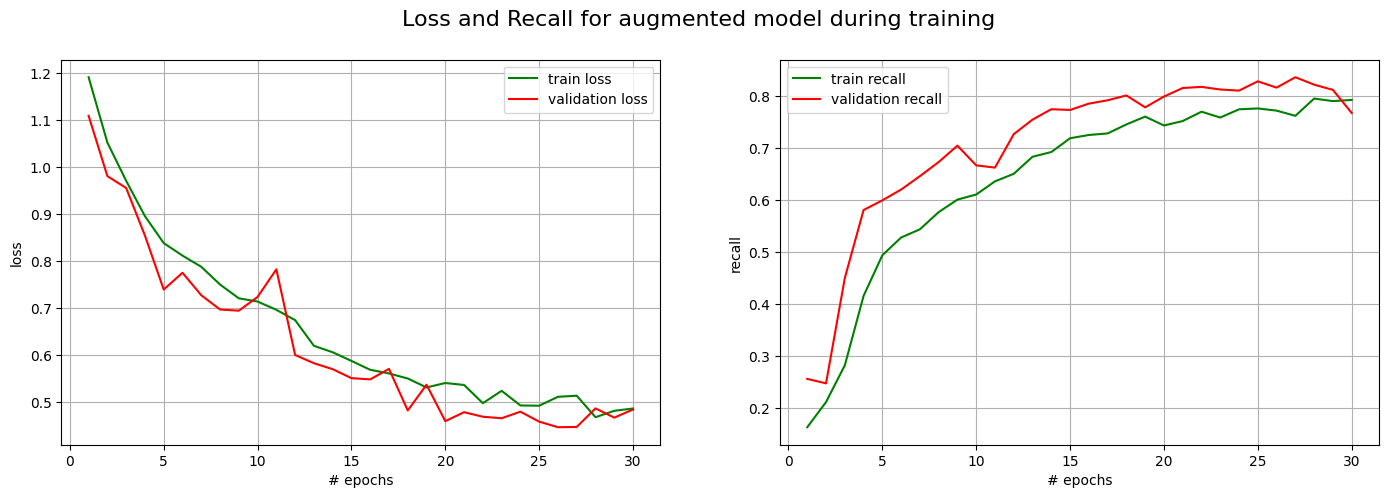

In [13]:
loss_recall_plot(augmented_train_log, 'Loss and Recall for augmented model during training')

We see that by using **augmentation** we were able to get rid of **overfitting** completely. Although we see that *recall* is much smaller than of the previous model.  

Possible solution - additional training.

### Additional training with augmented images

Before additional training, let's save an old model once again (in case it goes wrong):

In [14]:
augmented_model.save('..//save_files//models/augmented_backup.h5')

And continue training:

In [15]:
additional_training_aug_history = augmented_model.fit(train_generator_aug, steps_per_epoch=500, epochs=30,
                                                  validation_data=validation_generator, validation_steps=175,
                                                  callbacks=[stop_early], verbose=1)

Epoch 1/30
500/500 [==============================] - 152s 303ms/step - loss: 0.4778 - recall: 0.7888 - val_loss: 0.4847 - val_recall: 0.8071
Epoch 2/30
500/500 [==============================] - 152s 304ms/step - loss: 0.4619 - recall: 0.7946 - val_loss: 0.4772 - val_recall: 0.7914
Epoch 3/30
500/500 [==============================] - 152s 304ms/step - loss: 0.4567 - recall: 0.8019 - val_loss: 0.3977 - val_recall: 0.8350
Epoch 4/30
500/500 [==============================] - 152s 303ms/step - loss: 0.4599 - recall: 0.7996 - val_loss: 0.4064 - val_recall: 0.8236
Epoch 5/30
500/500 [==============================] - 152s 303ms/step - loss: 0.4532 - recall: 0.8099 - val_loss: 0.4674 - val_recall: 0.8236
Epoch 6/30
500/500 [==============================] - 152s 303ms/step - loss: 0.4362 - recall: 0.8054 - val_loss: 0.5054 - val_recall: 0.8414
Epoch 7/30
500/500 [==============================] - 153s 306ms/step - loss: 0.4436 - recall: 0.8106 - val_loss: 0.4325 - val_recall: 0.8079
Epoch 

In [16]:
additional_augmented_train_log = additional_training_aug_history.history
additional_augmented_num_epochs = np.arange(1, len(baseline_train_log['loss'])+1)

save_data(additional_augmented_train_log, 'train_log', '../save_files/train_log/additional_augmented_train_log.pkl')
save_data(additional_augmented_num_epochs, 'epochs', '../save_files/train_log/additional_augmented_num_epochs.pkl')

object successfully saved to: ../save_files/train_log/additional_augmented_train_log.pkl.
object successfully saved to: ../save_files/train_log/additional_augmented_num_epochs.pkl.


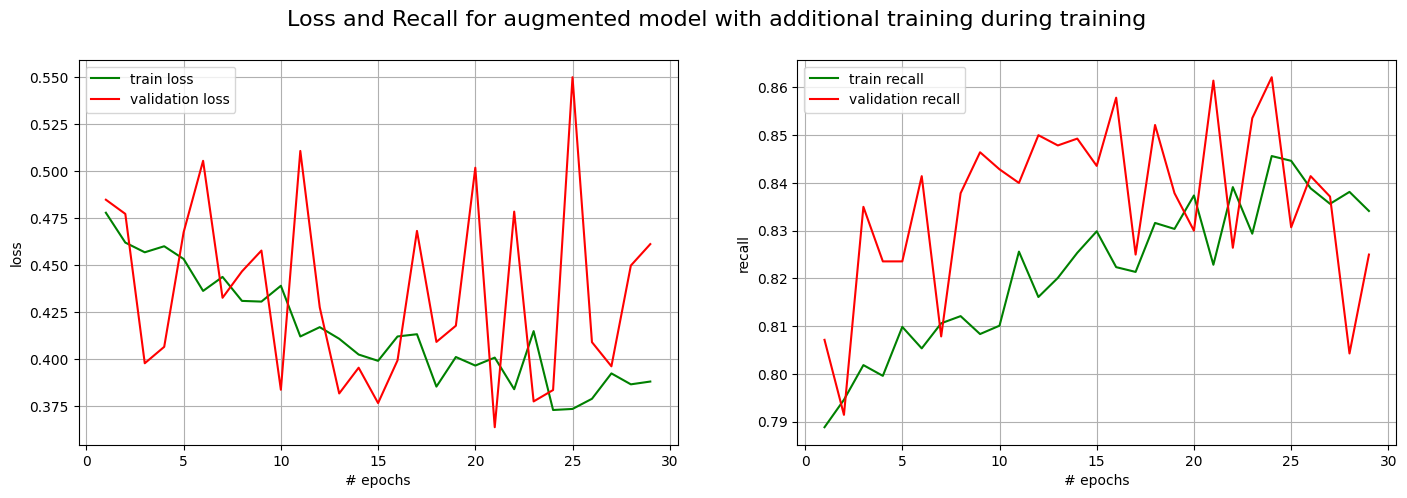

In [17]:
loss_recall_plot(additional_augmented_train_log, 'Loss and Recall for augmented model with additional training during training')

Additional training didn't help.  
  
Let's now try another approach:

### Less augmentation

Let's now see what happens if we add a little bit of augmentation.  
  
In addition to that, we will also add one *Dropout* layer:

In [5]:
train_datagen_aug_small = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False
)

train_generator_aug_small = train_datagen_aug_small.flow_from_dataframe(df_train, '..\\data\\raw\\merged_data\\',
                                                                  x_col='image_path', y_col='label',
                                                                  target_size=(512, 512), batch_size=8,
                                                                  class_mode='categorical', validate_filenames=False)

Found 4213 non-validated image filenames belonging to 4 classes.


In [6]:
tf.keras.backend.clear_session()

dropout_augmented_model = models.Sequential([

        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(512, 512, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(4, activation='softmax')
])

dropout_augmented_model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.Recall()])

In [7]:
dropout_augmented_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

The train process is the same as for the previous models.

In [8]:
dropout_augmented_history_train = dropout_augmented_model.fit(train_generator_aug_small, steps_per_epoch=500, epochs=60,
                                                      validation_data=validation_generator, validation_steps=175,
                                                      callbacks=[stop_early], verbose=1)

Epoch 1/60
500/500 [==============================] - 201s 353ms/step - loss: 0.9417 - recall: 0.5109 - val_loss: 0.5395 - val_recall: 0.7629
Epoch 2/60
500/500 [==============================] - 144s 287ms/step - loss: 0.5872 - recall: 0.7188 - val_loss: 0.4314 - val_recall: 0.8414
Epoch 3/60
500/500 [==============================] - 144s 288ms/step - loss: 0.4506 - recall: 0.7988 - val_loss: 0.5368 - val_recall: 0.8121
Epoch 4/60
500/500 [==============================] - 142s 283ms/step - loss: 0.4127 - recall: 0.8205 - val_loss: 0.3901 - val_recall: 0.8550
Epoch 5/60
500/500 [==============================] - 139s 278ms/step - loss: 0.3929 - recall: 0.8359 - val_loss: 0.2921 - val_recall: 0.8850
Epoch 6/60
500/500 [==============================] - 139s 278ms/step - loss: 0.3468 - recall: 0.8591 - val_loss: 0.2899 - val_recall: 0.8871
Epoch 7/60
500/500 [==============================] - 139s 278ms/step - loss: 0.3390 - recall: 0.8626 - val_loss: 0.3148 - val_recall: 0.8793
Epoch 

In [9]:
dropout_augmented_train_log = dropout_augmented_history_train.history
dropout_augmented_num_epochs = np.arange(1, len(baseline_train_log['loss'])+1)

save_data(dropout_augmented_train_log, 'train_log', '../save_files/train_log/dropout_augmented_train_log.pkl')
save_data(dropout_augmented_num_epochs, 'epochs', '../save_files/train_log/dropout_augmented_num_epochs.pkl')

object successfully saved to: ../save_files/train_log/dropout_augmented_train_log.pkl.
object successfully saved to: ../save_files/train_log/dropout_augmented_num_epochs.pkl.


Now to visualization:

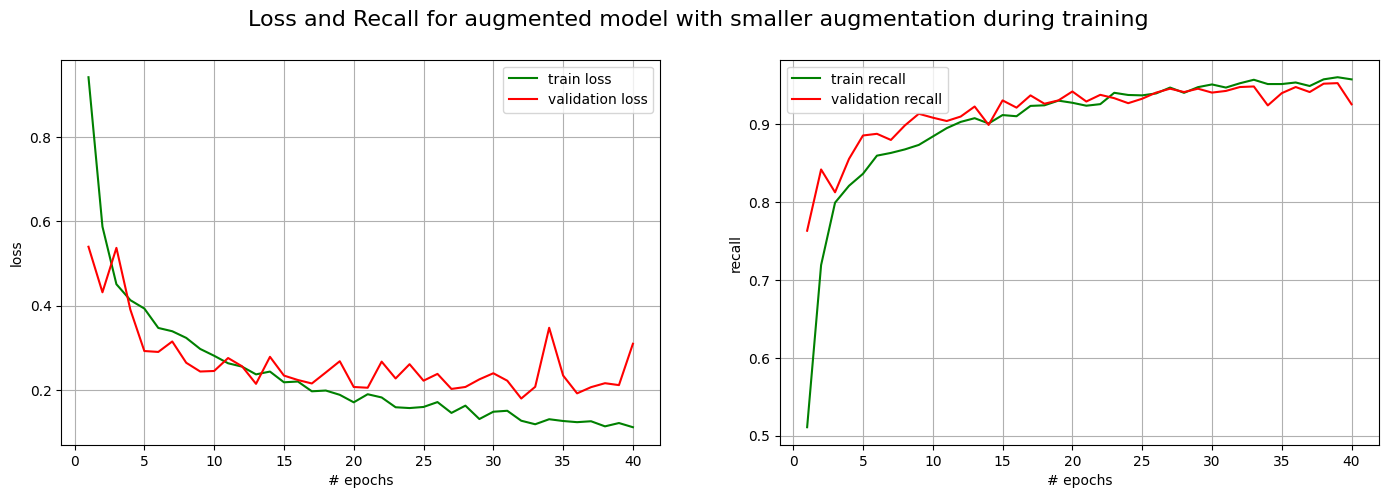

In [13]:
loss_recall_plot(dropout_augmented_train_log, 'Loss and Recall for augmented model with smaller augmentation during training')

We see that we have almost got rid of overfitting and were able to get pretty good results.

Now we save the trained model and make a backup for additional training:

In [15]:
dropout_augmented_model.save('../save_files/models/dropout_augmented.h5')

In [16]:
dropout_augmented_model.save('../save_files/models/dropout_augmented_backup.h5')

In [12]:
dropout_augmented_train_results = dropout_augmented_model.evaluate(train_generator_aug_small, batch_size=32, return_dict=True)
dropout_augmented_test_results = dropout_augmented_model.evaluate(test_generator, batch_size=32, return_dict=True)

save_data(dropout_augmented_train_results, 'evaluation_data', '../save_files/evaluation/dropout_augmented_train_results.pkl')
save_data(dropout_augmented_test_results, 'evaluation_data', '../save_files/evaluation/dropout_augmented_test_results.pkl')

176/176 [==============================] - 12s 67ms/step - loss: 0.4333 - recall: 0.9260
object successfully saved to: ../save_files/evaluation/dropout_augmented_train_results.pkl.
object successfully saved to: ../save_files/evaluation/dropout_augmented_test_results.pkl.


In [14]:
print('Evaluation results for model with less augmented images input:\n')
print('train loss:   ', dropout_augmented_train_results['loss'])
print('train recall: ', dropout_augmented_train_results['recall'])
print()
print('test loss:    ', dropout_augmented_test_results['loss'])
print('test recall:  ', dropout_augmented_test_results['recall'])

Evaluation results for model with augmented images input:

train loss:    0.10696247965097427
train recall:  0.9570377469062805

test loss:     0.433254599571228
test recall:   0.9259786605834961


However, let's run an additional round of training:

In [9]:
additional_dropout_augmented_history_train = dropout_augmented_model.fit(train_generator_aug_small, steps_per_epoch=500, epochs=20,
                                                                         validation_data=validation_generator, validation_steps=175,
                                                                         callbacks=[stop_early], verbose=1)

Epoch 1/20
500/500 [==============================] - 217s 338ms/step - loss: 0.1045 - recall: 0.9582 - val_loss: 0.2324 - val_recall: 0.9536
Epoch 2/20
500/500 [==============================] - 150s 299ms/step - loss: 0.1072 - recall: 0.9567 - val_loss: 0.2255 - val_recall: 0.9479
Epoch 3/20
500/500 [==============================] - 142s 284ms/step - loss: 0.1199 - recall: 0.9555 - val_loss: 0.2572 - val_recall: 0.9457
Epoch 4/20
500/500 [==============================] - 143s 285ms/step - loss: 0.0916 - recall: 0.9665 - val_loss: 0.2378 - val_recall: 0.9486
Epoch 5/20
500/500 [==============================] - 143s 286ms/step - loss: 0.0992 - recall: 0.9657 - val_loss: 0.2265 - val_recall: 0.9579
Epoch 6/20
500/500 [==============================] - 142s 284ms/step - loss: 0.0877 - recall: 0.9670 - val_loss: 0.1778 - val_recall: 0.9543
Epoch 7/20
500/500 [==============================] - 142s 284ms/step - loss: 0.0994 - recall: 0.9627 - val_loss: 0.2147 - val_recall: 0.9543
Epoch 

In [10]:
dropout_augmented_model.save('../save_files/models/dropout_augmented.h5')

In [11]:
additional_dropout_augmented_train_log = additional_dropout_augmented_history_train.history
additional_dropout_augmented_num_epochs = np.arange(1, len(baseline_train_log['loss'])+1)

save_data(additional_dropout_augmented_train_log, 'train_log', '../save_files/train_log/additional_dropout_augmented_train_log.pkl')
save_data(additional_dropout_augmented_num_epochs, 'epochs', '../save_files/train_log/additional_dropout_augmented_num_epochs.pkl')

object successfully saved to: ../save_files/train_log/additional_dropout_augmented_train_log.pkl.
object successfully saved to: ../save_files/train_log/additional_dropout_augmented_num_epochs.pkl.


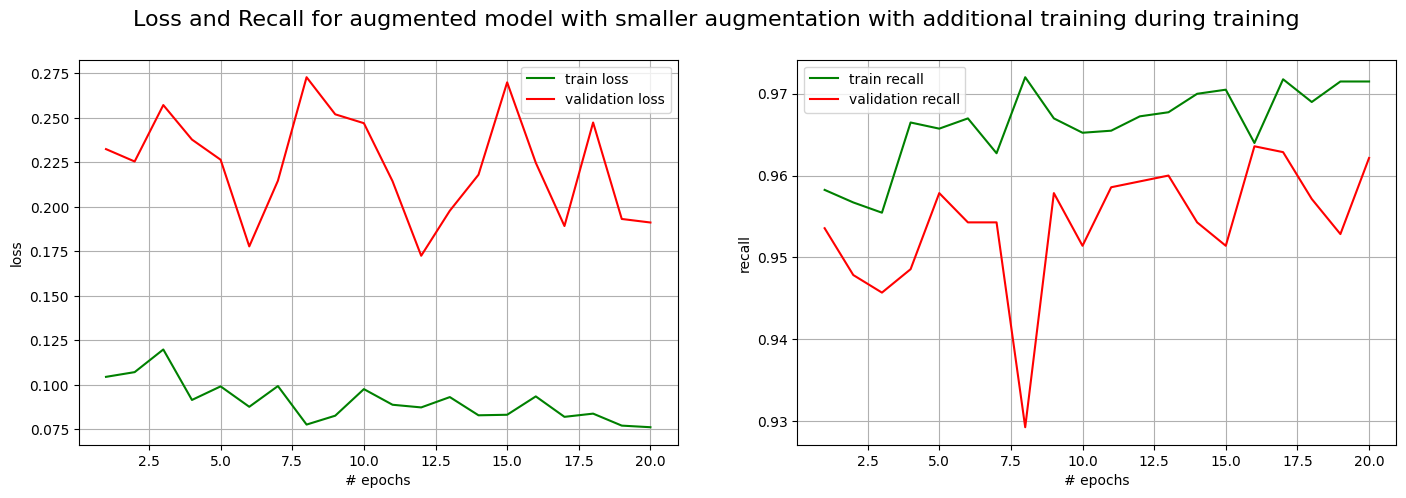

In [12]:
loss_recall_plot(additional_dropout_augmented_train_log, 'Loss and Recall for augmented model with smaller augmentation with additional training during training')